In [172]:
from collections import Counter
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import *

%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format
plt.style.use("bmh")

In [213]:
def mean_normalize(df):
    return (df - df.mean()) / df.std()

def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

In [2]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [3]:
tweets_df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

# Exploratory Data Analysis

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729129 entries, 1331706590525874184 to 1000259808442961920
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userid                    729129 non-null  string        
 1   user_display_name         729129 non-null  string        
 2   user_screen_name          729129 non-null  string        
 3   user_reported_location    545336 non-null  string        
 4   user_profile_description  684476 non-null  string        
 5   user_profile_url          448380 non-null  string        
 6   follower_count            729129 non-null  int64         
 7   following_count           729129 non-null  int64         
 8   account_creation_date     729129 non-null  datetime64[ns]
 9   account_language          729129 non-null  string        
 10  tweet_language            603007 non-null  string        
 11  tweet_text                729129 n

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to umi7TfGCQ73OtREt5v8BMjNBHbg96LnkEmH65RO8Ts=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         374 non-null    string        
 1   user_screen_name          374 non-null    string        
 2   user_reported_location    162 non-null    string        
 3   user_profile_description  274 non-null    string        
 4   user_profile_url          44 non-null     string        
 5   follower_count            374 non-null    int64         
 6   following_count           374 non-null    int64         
 7   account_creation_date     374 non-null    datetime64[ns]
 8   account_language          374 non-null    string        
 9   file                      374 non-null    string        
 10  campaign                  374 non-null    string        
 11  releas

<IPython.core.display.Javascript object>


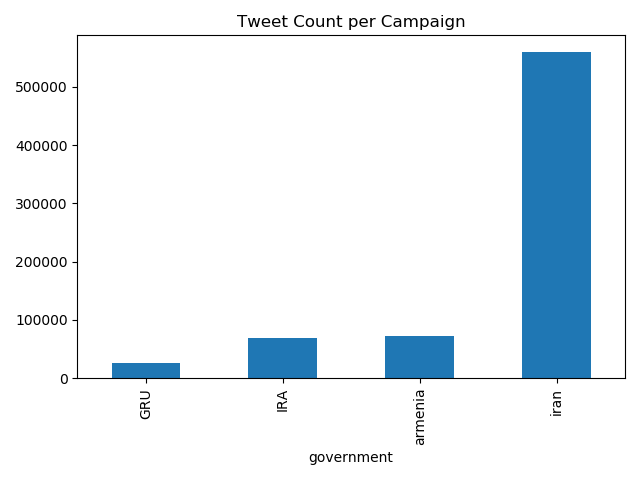

In [9]:
(tweets_df.groupby('government')
  .size()
).plot(kind='bar', title='Tweet Count per Campaign')
plt.tight_layout()

In [94]:
campaign = tweets_df.loc[:][tweets_df['campaign'] =='iran202012']
campaign_users = user_df.loc[:][user_df['campaign'] =='iran202012']

In [178]:
print('Campaign-identified users: {}'.format(len(campaign_users)))

start = (campaign
         .loc[:]['tweet_time']
         .min()
)
end = (campaign
         .loc[:]['tweet_time']
         .max()
)
print('Campaign duration: {}'.format(end - start))

Campaign-identified users: 238
Campaign duration: 4130 days 04:12:00


In [97]:
print('Total tweets: {}'.format(len(campaign)))
print('Tweets per user:')
tweets_per_user = (campaign
                .groupby('userid')
                .size()
                .describe()
                .astype('int')
)[['mean','std','min','max']]
print(tweets_per_user)
print('Tweets from max user: {:.2%}'
      .format(tweets_per_user.loc['max'] / len(campaign)))

Total tweets: 560571
Tweets per user:
mean      2682
std      21022
min          1
max     302648
dtype: int64
Tweets from max user: 53.99%


In [98]:
print('Max user:')
max_user = (campaign
           .groupby('userid')
           .size()
           .idxmax()
           )
max_user

Max user:


'213589457'

Interestingly, the top-tweeting user for the Iran campaign is a Spanish-language account, with a user-reported location of Teheran.

In [99]:
campaign_users.loc[max_user]

user_display_name                                                    HispanTV
user_screen_name                                                     Hispantv
user_reported_location                                                Teherán
user_profile_description    Medio no corporativo, que se hace eco de las r...
user_profile_url                                       http://t.co/SU1GJqdDNM
follower_count                                                         161512
following_count                                                            31
account_creation_date                                     2010-11-09 00:00:00
account_language                                                           es
file                        hashed_2020_12_iran_202012_iran_202012_users_c...
campaign                                                           iran202012
release                                                                202012
government                                                      

#### To do: compare these distributions with general twitter pattern

In [182]:
title = 'Tweet counts per user'
print(title)
tweet_counts_per_user = (campaign
                        .groupby('userid')
                        .size()
                       )
tweet_counts_per_user.sort_values(ascending=False)

Tweet counts per user


userid
213589457                                       302648
T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=      18851
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=     14115
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=     13304
1067814896706994176                              12790
                                                 ...  
Q1Gccf8mIb7MdLjvb7eKThktteoMMAIeTAfo+HbjtWc=         1
xRguKYrfYy7pBmb6LzrFQw9XUmjThHyA+WSFqP7u5E=          1
OiGJvJyTyR77VscoQBz5HEs8pfB+Npnmhfd1CIVx0As=         1
O2v43Q2piVdfKPC6mJtJmo4O0JBPtMG2F4CucMA3FA=          1
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=         1
Length: 209, dtype: int64

<IPython.core.display.Javascript object>


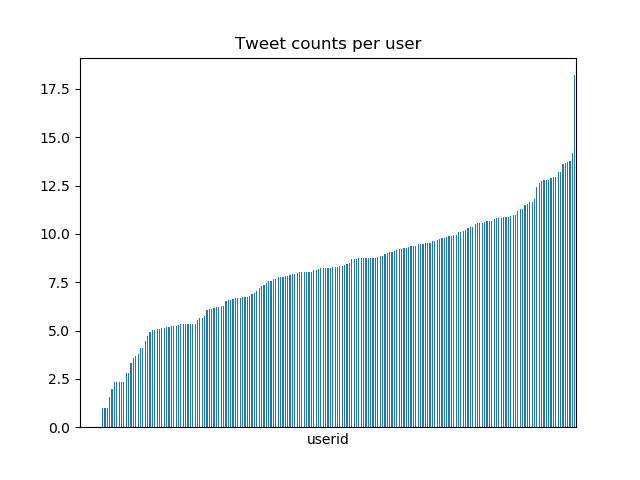

In [102]:
fig, ax = plt.subplots()
ax = np.log2(tweet_counts_per_user
 .sort_values()
).plot(kind='bar', xticks=([]), title=title)
fig.show()

In [183]:
title = ('Like counts per user:')
print(title)
like_counts_per_user = (campaign
                        .groupby('userid')
                        .sum()
                        .loc[:]['like_count']
                       )
like_counts_per_user.sort_values(ascending=False)

Like counts per user:


userid
213589457                                       1799708
DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=     179460
PpOfb+YOWXe3t9rDg7EJ55neK4hKxdNioiA91GAANs=       97741
1099221870530961408                               87908
1091795789263921152                               64480
                                                 ...   
aJdvwfdmprSTKVP0S4dQmEQ3nT5qVnRyYyIdXnYOdyo=          0
djt7FLKLI76zIdPZHvdLNKMth8pEH8+zHauTj5wBc8=           0
BAszjp3oepGsQa6QkPdEbzGMOFLIUxZpwR7JP7NGL8=           0
iBo2Ov46z4inKNY4kNAWbcTtVUSDdEjZkwTBJdpQ5bk=          0
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=          0
Name: like_count, Length: 209, dtype: int64

In [103]:
(like_counts_per_user
 .describe()
 .astype('int')
)[['mean','std','min','max']]

mean      13928
std      125374
min           0
max     1799708
Name: like_count, dtype: int64

<IPython.core.display.Javascript object>


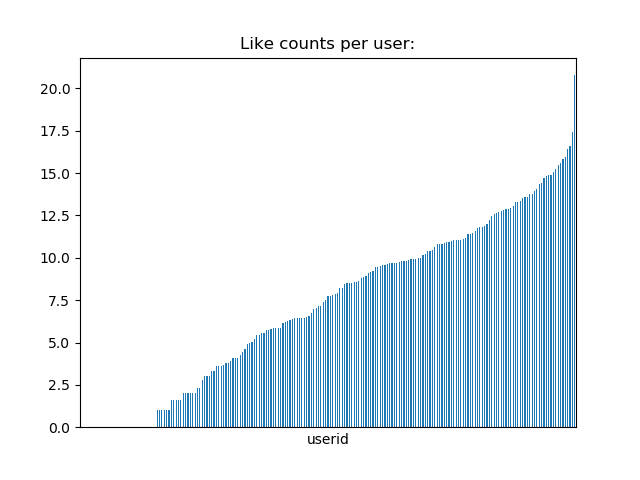

/home/sarah/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [143]:
fig, ax = plt.subplots()

ax = np.log2(like_counts_per_user
 .sort_values()
).plot(kind='bar', xticks=([]), title=title)

fig.show()

In [181]:
most_liked_tweet = campaign['like_count'].idxmax()
print('"',campaign
 .loc[most_liked_tweet]['tweet_text'],
      '"'
)
print('\nNumber of likes: {}'.format(campaign['like_count'].max()))

" I lived with Kavanaugh at Yale.The FBI never returned my call.

Many were in the same place; they tried to get in contact with FBI, with no luck. Now GOP senators are claiming FBI report showed 'nothing they didn't already know'. Bullshit
https://t.co/aIDK2IZ7ek 

#KavanaughLied "

Number of likes: 63863


In [184]:
(campaign
 .loc[most_liked_tweet][counts]
)

like_count       63863
quote_count       1155
reply_count       1385
retweet_count    26269
Name: 1173315426039869441, dtype: object

In [109]:
most_liked_tweet_user = (campaign
            .loc[most_liked_tweet]['userid']
            )
users.df.loc[most_liked_tweet_user][:-4]

user_display_name                DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_screen_name                 DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_reported_location                                             California
user_profile_description    "No one fixes the world alone."\n\n#BlueWave #...
user_profile_url                                                         <NA>
follower_count                                                           2439
following_count                                                          1164
account_creation_date                                     2019-08-18 00:00:00
account_language                                                           en
Name: DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=, dtype: object

Considering this most-liked tweet has an order of magnitude more likes than the next most-liked tweet, we could exclude this outlier in our analyses for a more accurate description of the campaign tweet distributions overall.

## Unique Users

In [173]:
def get_unique_ids(campaign, campaign_users):
    campaign_userids = (campaign_users
           .groupby('userid')
           .size()
           .index
          )
    tweet_userids = (campaign
                   .groupby('userid')
                   .size()
                   .index
                  )
    retweet_userids = (campaign
                   .loc[:]['retweet_userid']
                   .dropna()
                  )
    reply_userids = (campaign
                   .loc[:]['in_reply_to_userid']
                   .dropna()
                  )
    mention_userids = (campaign['user_mentions']
                # expand usernames into columns
                .explode()
                # melt wide table into duplicated tweets
                .reset_index()
                .melt(id_vars=['tweetid'],
                      value_name='mentioned_userid')
                # clean up
                .astype({'mentioned_userid':'string'})
                .drop(columns=['variable'])
                .join(campaign['userid'], on='tweetid')
                .dropna()
               ).loc[:]['mentioned_userid']
    
    return Counter(list(itertools.chain(*[campaign_userids,
                                            tweet_userids,
                                            retweet_userids,
                                            reply_userids,
                                            mention_userids,
                                           ])))

In [175]:
userids = dict(get_unique_ids(campaign, campaign_users))
print('Unique users:', len(userids))

Unique users: 61117


## Interactions

In [110]:
fields = ['follower_count',
         'following_count',
         'like_count',
         'quote_count',
         'reply_count',
         'retweet_count']
stats = ['mean',
         'std',
         'min',
         'max']

In [194]:
interactions_before = (campaign
                       .describe()
                      )

In [195]:
interactions_after = (campaign
                .drop(index=most_liked_tweet)
                .describe()
               )

In [196]:
(interactions_before
 .loc[stats][counts]
 .astype('int')
)

,like_count,quote_count,reply_count,retweet_count
mean,5,0,0,5
std,105,3,5,47
min,0,0,0,0
max,63863,1155,2222,26269


The standard deviations of count measures are considerably smaller after removing the most-liked tweet:

In [197]:
(interactions_after
 .loc[stats][counts]
 .astype('int')
)

,like_count,quote_count,reply_count,retweet_count
mean,5,0,0,5
std,61,2,5,32
min,0,0,0,0
max,18145,1109,2222,9967


The plot below gives some indication of the different scales of different types of tweet interactions.

<IPython.core.display.Javascript object>


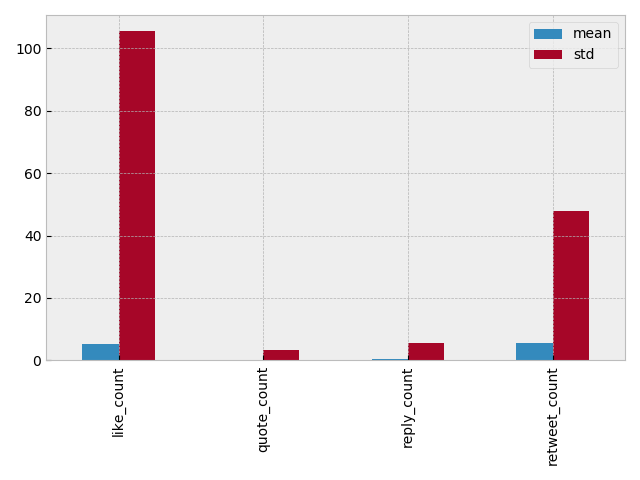

In [177]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count']
plot_stats = ['mean',
             'std',
             ]

(interactions
 .T
 .loc[counts]
)[plot_stats].plot(kind='bar')
plt.tight_layout()
#ax.set_xlabel=([field.replace('_count', '') for field in fields])

Aggregate counts per user:

In [208]:
(campaign
    .groupby('userid')
    .sum()
    .loc[:][counts]
    .describe()
    .astype('int')
).loc[stats]

,like_count,quote_count,reply_count,retweet_count
mean,13928,644,1125,15008
std,125374,7383,8918,192315
min,0,0,0,0
max,1799708,106618,127521,2780592


<IPython.core.display.Javascript object>


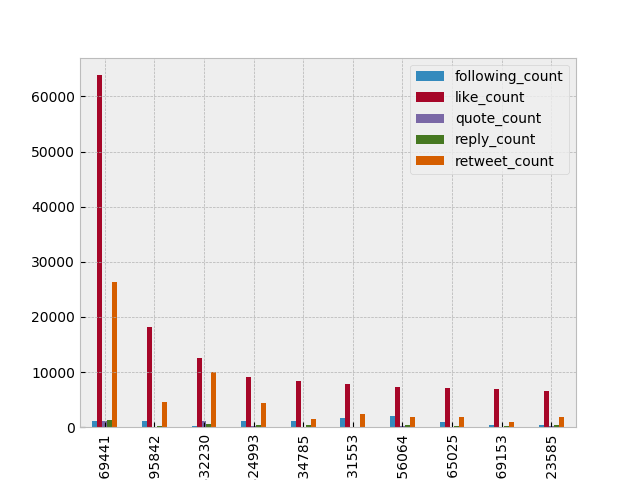

In [212]:
(campaign
 .loc[:][fields]
 .sort_values(by='like_count',ascending=False)
).head(10).plot(kind='bar')

#### To do: overall reaction count stats vs per-user

## Original Tweets vs. Retweets

In [162]:
def original_tweets(tweets):
    is_retweet = tweets['is_retweet'] == False
    return (tweets
            .loc[:][is_retweet]
           )

def retweets(tweets):
    is_retweet = tweets['is_retweet'] == True
    return (tweets
            .loc[:][is_retweet]
           )

def replies(tweets):
    is_reply = tweets['in_reply_to_tweetid'].notna()
    return (tweets
            .loc[:][is_reply]
           )

In [229]:
print('Original tweet count: {}'.format(len(original_tweets(campaign))))
print('Retweet count: {}'.format(len(retweets(campaign))))

Original tweet count: 460125
Retweet count: 100446


<IPython.core.display.Javascript object>


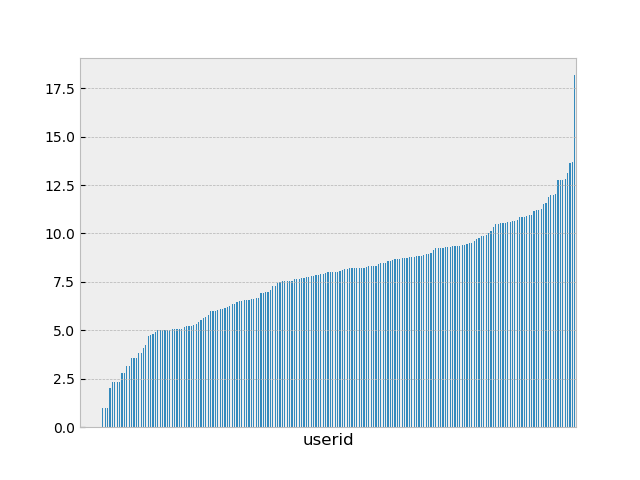

In [216]:
fig, ax = plt.subplots()
ax = np.log2(original_tweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(kind='bar',xticks=([]))
fig.show()

<IPython.core.display.Javascript object>


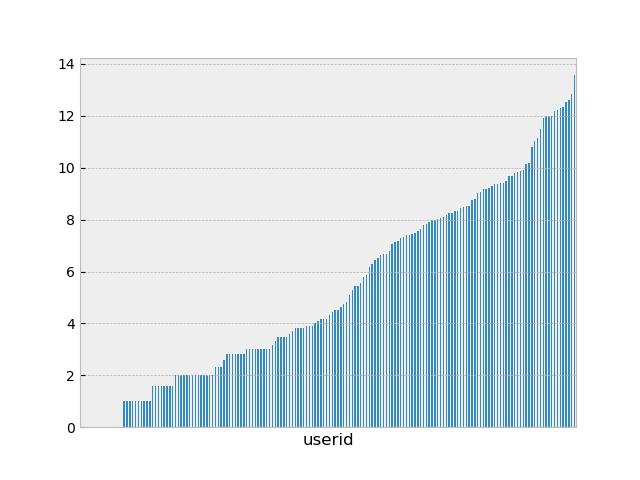

In [214]:
fig, ax = plt.subplots()
ax = np.log2(retweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(kind='bar',xticks=([]))
fig.show()

In [222]:
(original_tweets(campaign)
 .describe()
).loc[stats][counts]

,like_count,quote_count,reply_count,retweet_count
mean,6.33,0.29,0.51,6.82
std,116.32,3.52,6.10,52.80
min,0.00,0.00,0.00,0.00
max,63863.00,1155.00,2222.00,26269.00


In [223]:
(retweets(campaign)
 .describe()
).loc[stats][counts]

,like_count,quote_count,reply_count,retweet_count
mean,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00


We see here that we apparently do not have reaction count data for retweets, indicating that we may need to treat those values as missing when considering reaction statistics.

## User connections

In [ ]:
# internal retweets: users in campaign retweeting tweets from users in campaign
